In [1]:
import time
import os
import urllib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import missingno

from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

In [2]:
data_url = 'https://raw.githubusercontent.com/mo-amininasab/california_housing_AD/master/housing.csv'
data = pd.read_csv(data_url)

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.shape

(20640, 10)

## Take a Quick Look at the Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Dealing with missing data

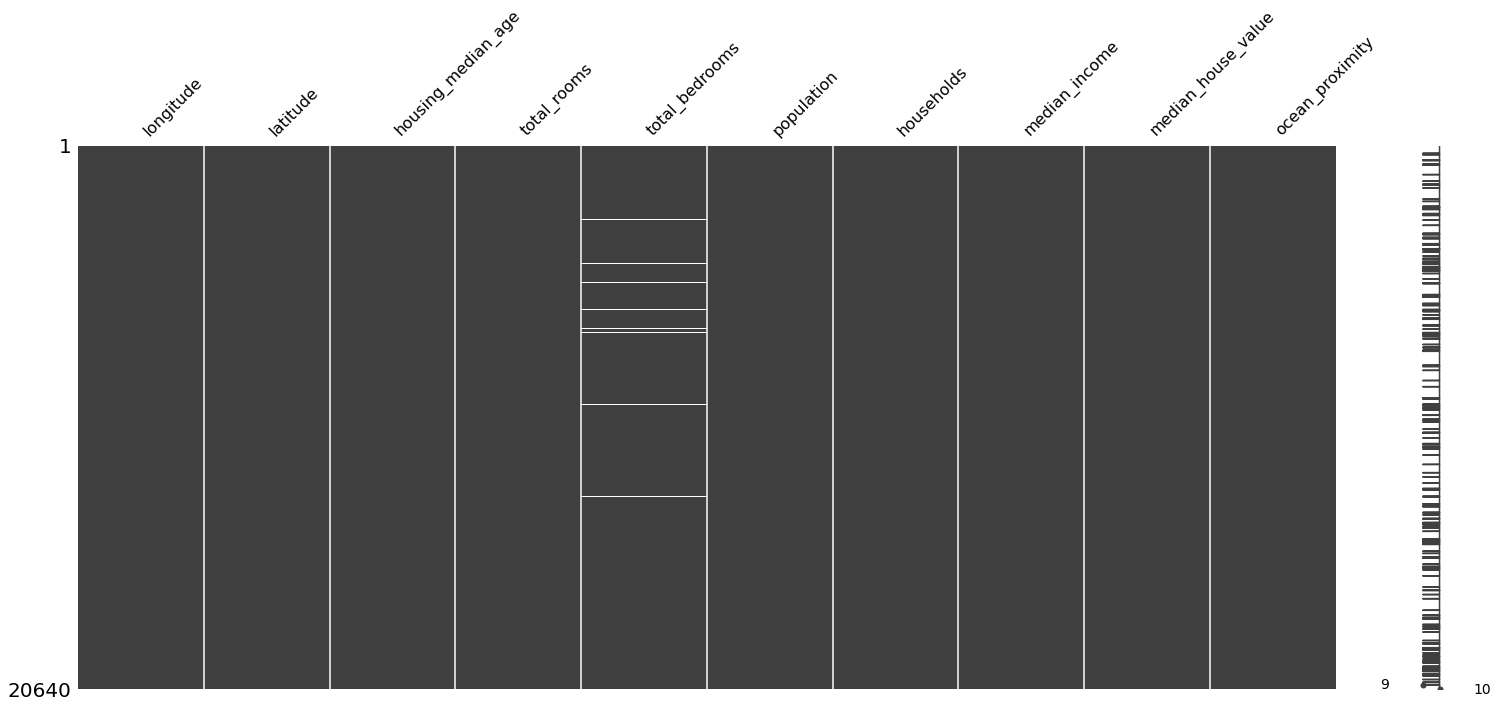

In [8]:
missingno.matrix(data)

In [9]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [10]:
data.isna().sum().sum() / data.shape[0]

0.01002906976744186

We can ignore 1% of the data.

In [11]:
data.dropna(subset=['total_bedrooms'], inplace=True)

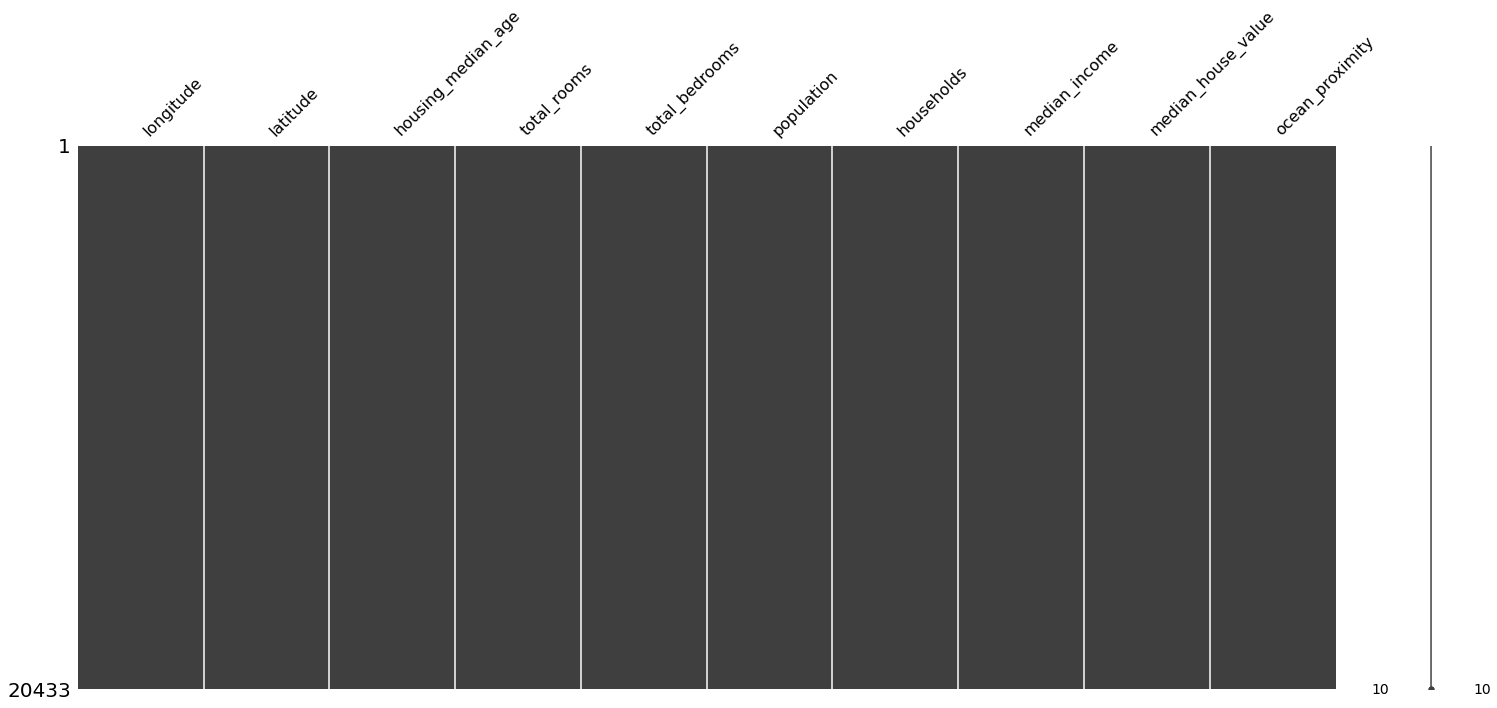

In [12]:
missingno.matrix(data)

## Visualizing the Data to Gain Insights

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa63f1ecd50>,
      dtype=object)

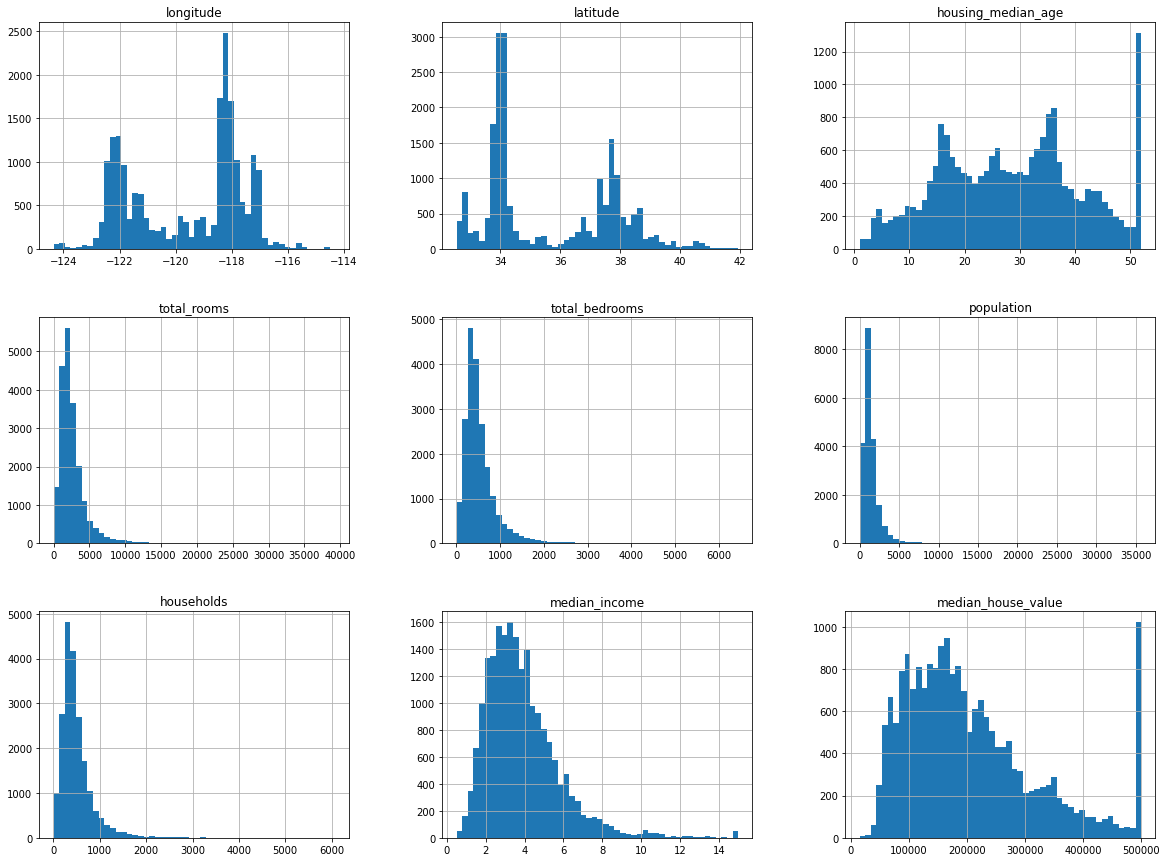

In [13]:
data.hist(bins=50, figsize=(20, 15))

### Visualizing Geographical Data

In [14]:
# Download the California image
images_path = os.path.join('.', "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7fa63e95a7d0>)

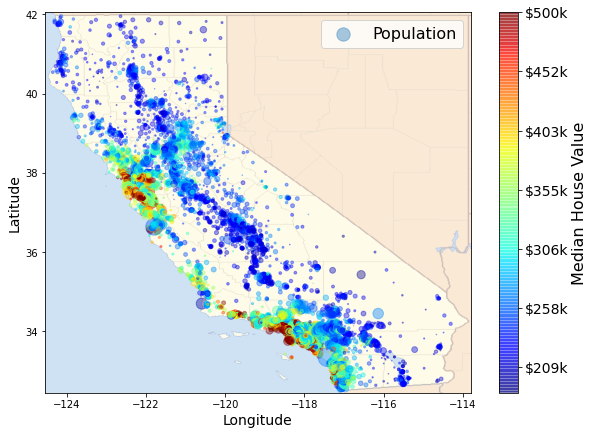

In [15]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(images_path, filename))
ax = data.plot(kind="scatter",
                  x="longitude",
                  y="latitude",
                  figsize=(10, 7),
                  s=data['population'] / 100,
                  label="Population",
                  c="median_house_value",
                  cmap=plt.get_cmap("jet"),
                  colorbar=False,
                  alpha=0.4)
plt.imshow(california_img,
           extent=[-124.55, -113.80, 32.45, 42.05],
           alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values / prices.max())
cbar.ax.set_yticklabels(["$%dk" % (round(v / 1000)) for v in tick_values],
                        fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Preparing the data for model

In [17]:
num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
cat_features= ['ocean_proximity']

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            # ('attribs_adder', CombinedAttributesAdder()),
                            ('std_scaler', StandardScaler())])

cat_transformer = Pipeline(
    [
        # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ],
)

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
],
                                 remainder='drop',
                                 n_jobs=-1)

In [18]:
data_prepared = preprocessor.fit_transform(data)

In [19]:
pd.DataFrame(data_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,2.128819,0.0,0.0,0.0,1.0,0.0
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,1.313626,0.0,0.0,0.0,1.0,0.0
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.258183,0.0,0.0,0.0,1.0,0.0
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,1.164622,0.0,0.0,0.0,1.0,0.0
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,1.172418,0.0,0.0,0.0,1.0,0.0


## Train models

### DBSCAN

In [20]:
t1 = time.time()
outlier_detection = DBSCAN(eps=1.5,
                           metric='euclidean',
                           min_samples=5,
                           n_jobs=-1)
dbscan_clusters = outlier_detection.fit_predict(data_prepared)
t2 = time.time()

In [21]:
print((t2-t1)/60)

0.25364623467127484


In [22]:
for i in range(len(dbscan_clusters)):
  if dbscan_clusters[i] != -1:
    dbscan_clusters[i] = 0

In [23]:
np.unique(dbscan_clusters, return_counts=True)

(array([-1,  0]), array([  265, 20168]))

In [24]:
data.iloc[np.argwhere(dbscan_clusters == -1).flatten()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,NEAR BAY
283,-122.16,37.79,22.0,12842.0,2048.0,4985.0,1967.0,5.9849,371000.0,NEAR BAY
508,-122.30,37.84,14.0,7355.0,2408.0,3100.0,2051.0,4.0018,143800.0,NEAR BAY
570,-122.24,37.72,5.0,18634.0,2885.0,7427.0,2718.0,7.6110,350700.0,NEAR BAY
576,-122.06,37.77,12.0,14316.0,2045.0,5781.0,2007.0,7.2634,341600.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20451,-118.90,34.26,5.0,25187.0,3521.0,11956.0,3478.0,6.9712,321300.0,<1H OCEAN
20527,-121.79,38.54,7.0,1777.0,513.0,4479.0,504.0,1.4653,310000.0,INLAND
20530,-121.76,38.57,11.0,15018.0,3008.0,7984.0,2962.0,3.1371,201800.0,INLAND
20544,-121.76,38.55,23.0,8800.0,1857.0,6330.0,1832.0,2.0650,219400.0,INLAND


In [25]:
def plot_anomalies(clusters, title, figsize=(20, 15)):
  california_img = mpimg.imread(os.path.join(images_path, filename))
  ax = data.plot(kind="scatter",
                    x="longitude",
                    y="latitude",
                    figsize=(20, 15),
                    s=data['population'] / 100,
                    label="Population",
                    c=clusters,
                    cmap=plt.get_cmap("Set1"),
                    colorbar=False,
                    alpha=0.4)
                    
  plt.imshow(california_img,
            extent=[-124.55, -113.80, 32.45, 42.05],
            alpha=0.5,
            cmap=plt.get_cmap("Set1"))

  plt.title(title)
  plt.ylabel("Latitude", fontsize=14)
  plt.xlabel("Longitude", fontsize=14)

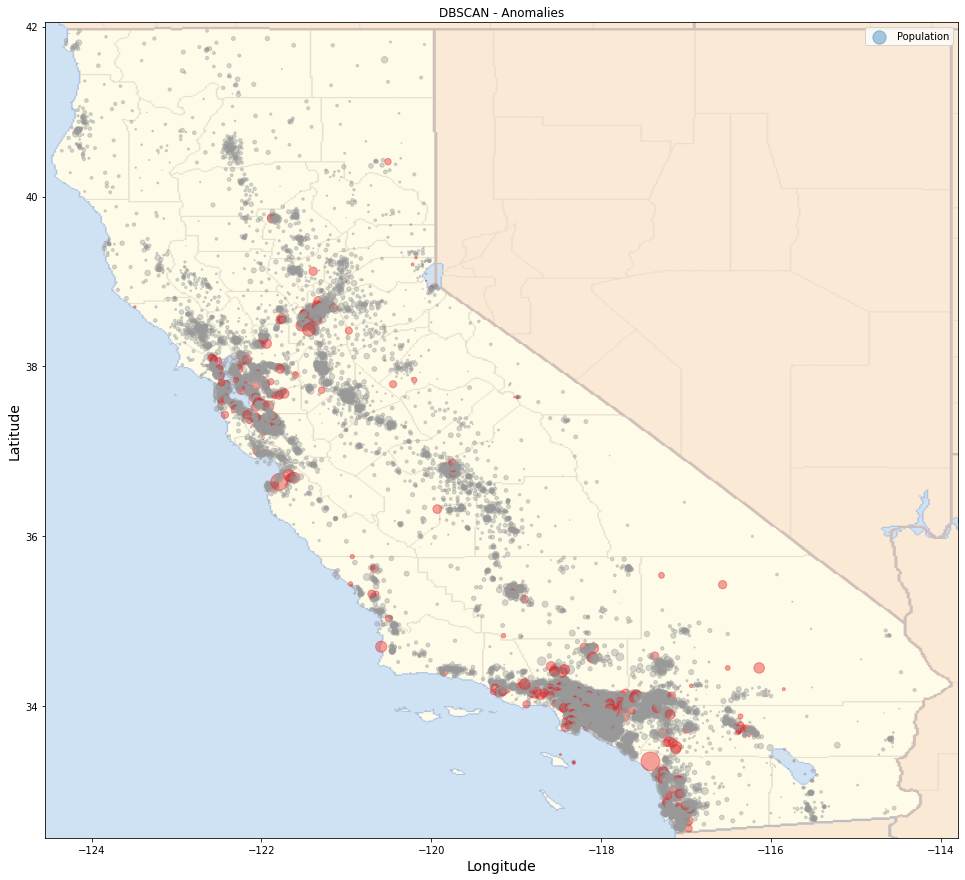

In [26]:
plot_anomalies(dbscan_clusters, 'DBSCAN - Anomalies')

### Isolation Forest

In [27]:
t1 = time.time()
ifor = IsolationForest(max_samples=100,
                       n_estimators=100,
                       random_state=42,
                       contamination=.05,
                       warm_start=True)
ifor_clusters = ifor.fit_predict(data_prepared)
t2 = time.time()

In [28]:
print((t2-t1)/60)

0.05807283322016398


In [29]:
for i in range(len(ifor_clusters)):
  if ifor_clusters[i] != -1:
    ifor_clusters[i] = 0

In [30]:
np.unique(ifor_clusters, return_counts=True)

(array([-1,  0]), array([ 1022, 19411]))

In [31]:
data.iloc[np.argwhere(ifor_clusters == -1).flatten()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY
61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20539,-121.71,38.56,20.0,8627.0,1516.0,4071.0,1466.0,4.2198,164100.0,INLAND
20543,-121.74,38.55,33.0,6861.0,1820.0,3717.0,1767.0,1.7311,182600.0,INLAND
20544,-121.76,38.55,23.0,8800.0,1857.0,6330.0,1832.0,2.0650,219400.0,INLAND
20563,-121.75,38.67,9.0,12139.0,2640.0,6837.0,2358.0,3.1250,132500.0,INLAND


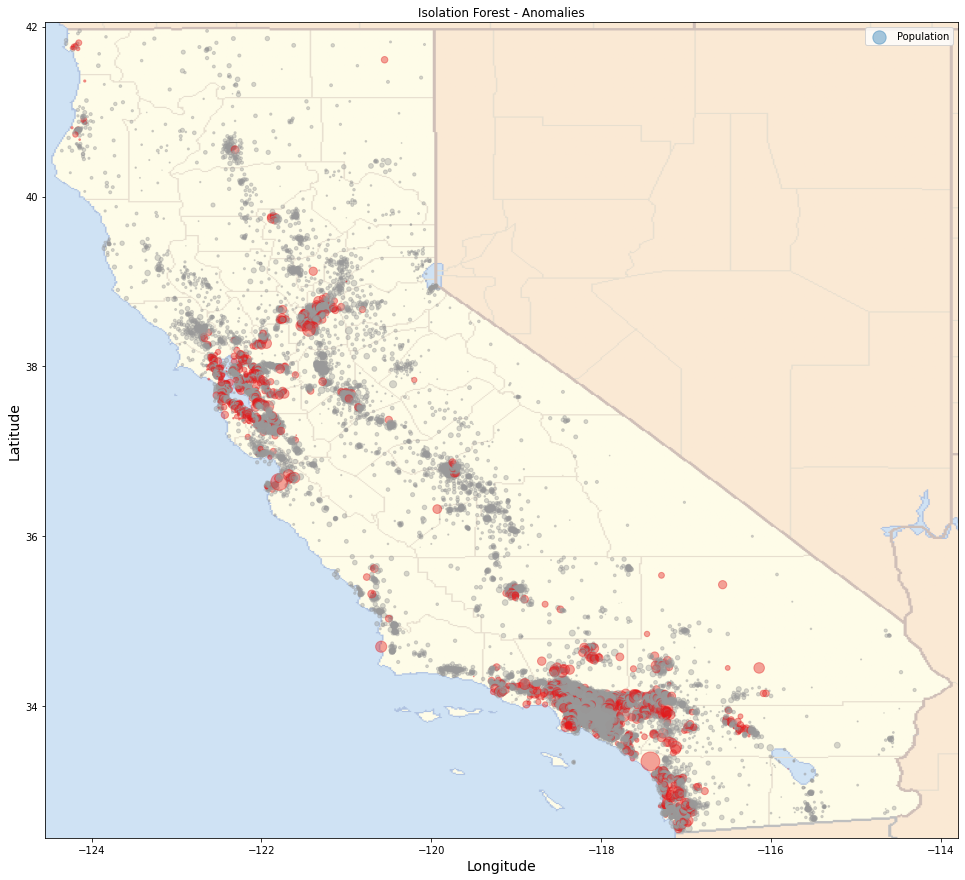

In [32]:
plot_anomalies(ifor_clusters, 'Isolation Forest - Anomalies')

### Local Outlier Factor

In [33]:
t1 = time.time()
lof = LocalOutlierFactor(n_neighbors=20, contamination=.02)
lof_clusters = lof.fit_predict(data_prepared)
t2 = time.time()

In [34]:
print((t2-t1)/60)

0.038039573033650714


In [35]:
for i in range(len(lof_clusters)):
  if lof_clusters[i] != -1:
    lof_clusters[i] = 0

In [36]:
np.unique(lof_clusters, return_counts=True)

(array([-1,  0]), array([  409, 20024]))

In [37]:
data.iloc[np.argwhere(lof_clusters == -1).flatten()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY
61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY
89,-122.27,37.80,52.0,249.0,78.0,396.0,85.0,1.2434,500001.0,NEAR BAY
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20248,-119.23,34.25,28.0,26.0,3.0,29.0,9.0,8.0000,275000.0,NEAR OCEAN
20297,-119.22,34.15,32.0,3152.0,596.0,3490.0,526.0,2.7250,450000.0,NEAR OCEAN
20349,-119.08,34.17,32.0,166.0,22.0,63.0,29.0,7.3004,125000.0,NEAR OCEAN
20443,-118.85,34.27,50.0,187.0,33.0,130.0,35.0,3.3438,500001.0,<1H OCEAN


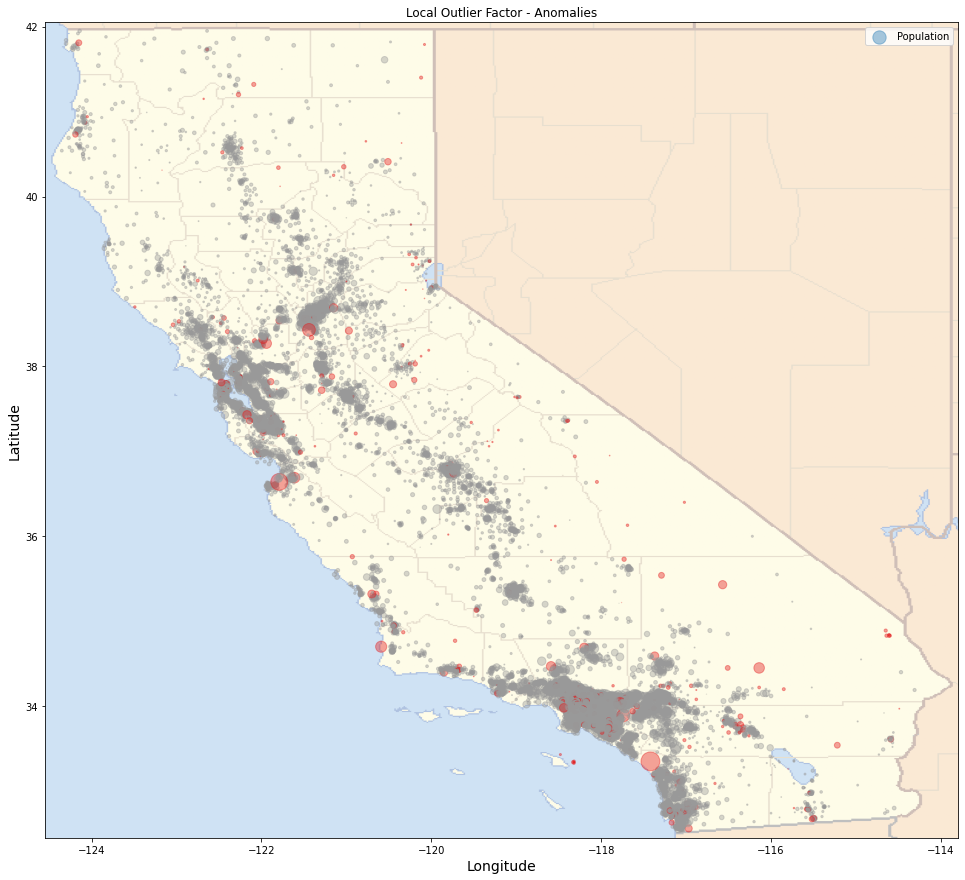

In [38]:
plot_anomalies(lof_clusters, 'Local Outlier Factor - Anomalies')

### Elliptic Envelope

In [39]:
t1 = time.time()
ee = EllipticEnvelope(contamination=.02, random_state=42)
ee_clusters = ee.fit_predict(data_prepared)
t2 = time.time()

In [40]:
print((t2-t1)/60)

0.05048489570617676


In [41]:
for i in range(len(ee_clusters)):
  if ee_clusters[i] != -1:
    ee_clusters[i] = 0

In [42]:
np.unique(ee_clusters, return_counts=True)

(array([-1,  0]), array([  409, 20024]))

In [43]:
data.iloc[np.argwhere(ee_clusters == -1).flatten()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,NEAR BAY
104,-122.26,37.81,34.0,5871.0,1914.0,2689.0,1789.0,2.8406,335700.0,NEAR BAY
116,-122.25,37.83,28.0,5022.0,1750.0,2558.0,1661.0,2.4234,218500.0,NEAR BAY
485,-122.26,37.86,35.0,5161.0,1744.0,3276.0,1742.0,1.6307,253600.0,NEAR BAY
508,-122.30,37.84,14.0,7355.0,2408.0,3100.0,2051.0,4.0018,143800.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20427,-118.80,34.19,4.0,15572.0,2222.0,5495.0,2152.0,8.6499,500001.0,<1H OCEAN
20440,-118.77,34.24,6.0,16222.0,2309.0,6700.0,2080.0,6.4963,308100.0,<1H OCEAN
20451,-118.90,34.26,5.0,25187.0,3521.0,11956.0,3478.0,6.9712,321300.0,<1H OCEAN
20527,-121.79,38.54,7.0,1777.0,513.0,4479.0,504.0,1.4653,310000.0,INLAND


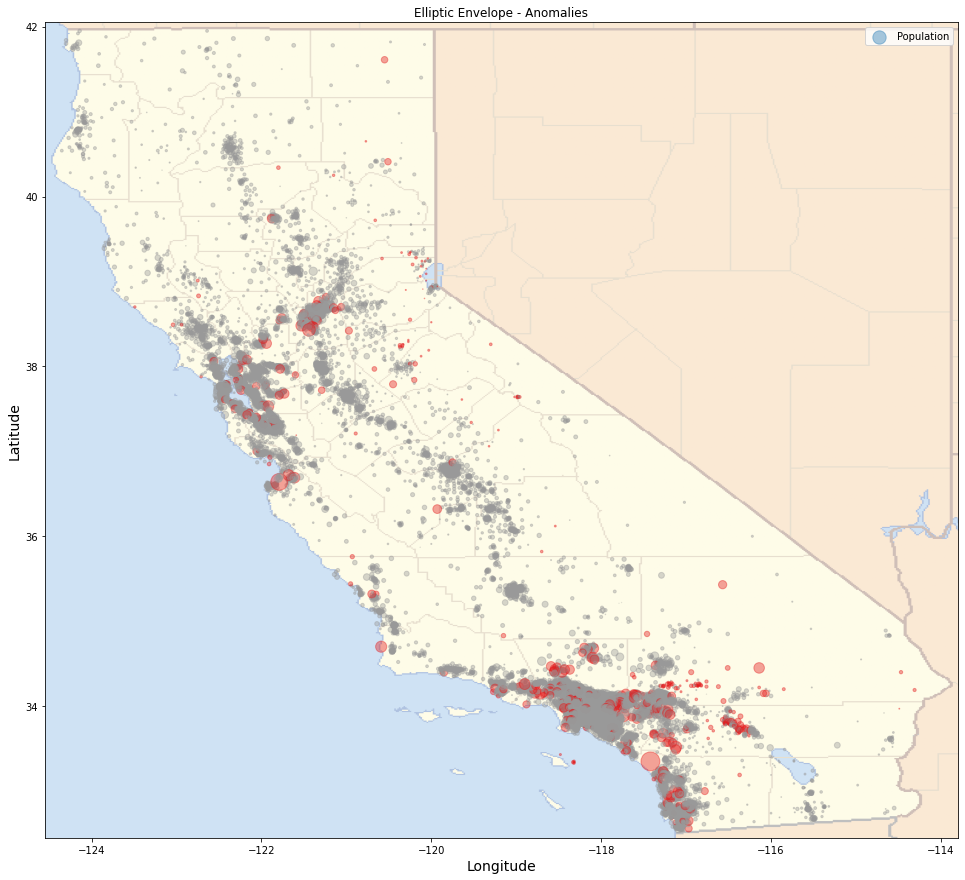

In [44]:
plot_anomalies(ee_clusters, 'Elliptic Envelope - Anomalies')

### One-Class SVM (OCSVM)

In [45]:
t1 = time.time()
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
ocsvm_clusters = ocsvm.fit_predict(data_prepared)
t2 = time.time()

In [46]:
print((t2-t1)/60)

0.24073702891667684


In [47]:
for i in range(len(ocsvm_clusters)):
  if ocsvm_clusters[i] != -1:
    ocsvm_clusters[i] = 0

In [48]:
np.unique(ocsvm_clusters, return_counts=True)

(array([-1,  0]), array([ 2043, 18390]))

In [49]:
data.iloc[np.argwhere(ocsvm_clusters == -1).flatten()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
55,-122.28,37.82,52.0,945.0,243.0,576.0,220.0,1.4113,83100.0,NEAR BAY
57,-122.28,37.82,52.0,1489.0,335.0,728.0,244.0,0.8172,85300.0,NEAR BAY
59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY
61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20544,-121.76,38.55,23.0,8800.0,1857.0,6330.0,1832.0,2.0650,219400.0,INLAND
20563,-121.75,38.67,9.0,12139.0,2640.0,6837.0,2358.0,3.1250,132500.0,INLAND
20592,-121.58,39.14,52.0,662.0,160.0,520.0,149.0,0.8928,55000.0,INLAND
20627,-121.32,39.13,5.0,358.0,65.0,169.0,59.0,3.0000,162500.0,INLAND


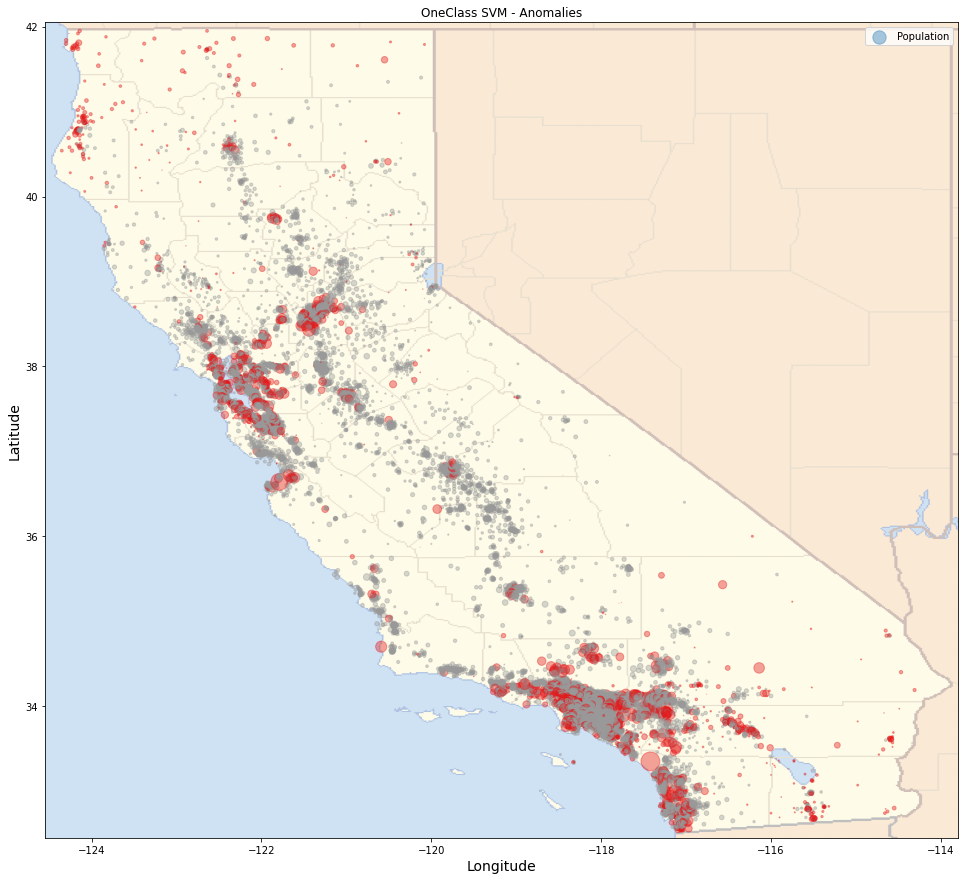

In [50]:
plot_anomalies(ocsvm_clusters, 'OneClass SVM - Anomalies')